# **Signature Verification**

Signature Verification System is a technology capable of matching a human signature from a digital image or a video frame against a database of signatures, typically employed to authenticate users through ID verification services, works by pinpointing and measuring handwritten signature features from a given image.

We'll be building a Signature Verification model that uses Siamese Networks to give us a distance value that indicates whether 2 images are same or different.

The Dataset
We'll be using the Handwritten Signature dataset.

In [1]:
import os
import cv2
import time
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

('2.11.0', '1.21.6')

## Reading the Dataset
We're reading the folders and splitting them into train and test set for training purposes.

In [2]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

# ROOT = "/kaggle/input/signature-varification/CV_2023_SC_Dataset"
name = "Copy of "

def read_image(dir,index):
    path = os.path.join(dir, index[0], (name + index[1]) )
    image = cv2.imread(path)
#     print("image path : {}".format(path))
    image = cv2.resize(image,(256,256))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [3]:
import pandas as pd
# training csv's
PersonA_train_data = pd.read_csv('/kaggle/input/signature-verification-and-identification/CSV files/Train/Copy of personA_SigVerificationTrainLabels.csv')
PersonB_train_data = pd.read_csv('/kaggle/input/signature-verification-and-identification/CSV files/Train/Copy of personB_SigVerificationTrainLabels.csv')
PersonC_train_data = pd.read_csv('/kaggle/input/signature-verification-and-identification/CSV files/Train/Copy of personC_SigVerificationTrainLabels.csv')
PersonD_train_data = pd.read_csv('/kaggle/input/signature-verification-and-identification/CSV files/Train/Copy of personD_SigVerificationTrainLabels.csv')
PersonE_train_data = pd.read_csv('/kaggle/input/signature-verification-and-identification/CSV files/Train/Copy of personE_SigVerificationTrainLabels.csv')

# testing csv's
PersonA_test_data = pd.read_csv('/kaggle/input/signature-verification-and-identification/CSV files/Test/Copy of personA_SigVerificationTestLabels.csv')
PersonB_test_data = pd.read_csv('/kaggle/input/signature-verification-and-identification/CSV files/Test/Copy of personB_SigVerificationTestLabels.csv')
PersonC_test_data = pd.read_csv('/kaggle/input/signature-verification-and-identification/CSV files/Test/Copy of personC_SigVerificationTestLabels.csv')
PersonD_test_data = pd.read_csv('/kaggle/input/signature-verification-and-identification/CSV files/Test/Copy of personD_SigVerificationTestLabels.csv')
PersonE_test_data = pd.read_csv('/kaggle/input/signature-verification-and-identification/CSV files/Test/Copy of personE_SigVerificationTestLabels.csv')

PersonA_test_data.head(8)

,image_name,label
0,personA_2.png,forged
1,personA_42.png,forged
2,personA_33.png,forged
3,personA_20.png,forged
4,personA_29.png,real
5,personA_13.png,real
6,personA_27.png,real
7,personA_10.png,real


## Creating Triplets
We use the train and test list to create triplets of (anchor, postive, negative) face data, where positive is the same person and negative is a different person than anchor.

In [4]:
def create_triplets(directory, folder_list, max_files=10):
    triplets = []
    csv_list = []
    x = -1
    folders = list(folder_list.keys()) # list of folders(classes)
    if directory == train_dir :
      csv_list = [PersonD_train_data,PersonA_train_data,PersonE_train_data,PersonC_train_data,PersonB_train_data]
      x = 20
    else : 
      csv_list = [PersonD_test_data,PersonA_test_data,PersonE_test_data,PersonC_test_data,PersonB_test_data]
      x = 4
    index = 0
    for folder in folders: # f every folder((class) of train/test
        data = csv_list[index]
        forged = data.iloc[:x,0]
        real = data.iloc[x:,0]
        num_files = x
        # path = os.path.join(directory, folder) # get full path of this folder : (dir/folder)
        # files = list(os.listdir(path))[:max_files] # return all(only max_files = 10) files(images) in the given folder(class) path
        # num_files = len(files) # length of all training/testing images of the current folder(class)
        
        for i in range(num_files-1): # n files
            for j in range(i+1, num_files): # m remain files
                anchor = (folder, real[i+x]) # set the first image as anchor_tuple containing (folder_name, first_img.jpg)
                positive = (folder, real[j+x])# set rest of images as postive_tuple containing (folder_name, rest_images.jpg)
                ''' example:   #1 iteration : a=(class,1st), p=(class,2nd), n = (diff_rand_class, rand_img)
                               #2 iteration : a=(class,1st), p=(class,3rd), n = (diff_rand_class, rand_img)
                               .
                               .
                               #m iteration : a=(class,1st), p=(class,mth), n = (diff_rand_class, rand_img)
                               #nm iteration : a=(class,nth), p=(class,mth), n = (diff_rand_class, rand_img)'''
                # neg_folder = folder
                # while neg_folder == folder: # if (-ve_folder == +ve_folder) then, random pick another different folder
                #     neg_folder = random.choice(folders)
                # neg_file = random.randint(0, folder_list[neg_folder]-1) # pick random img in that random folder from (0--># of files of this folder(dic[folder].value))
                negative = (folder, forged[i])

                triplets.append((anchor, positive, negative))
        index += 1
            
    random.shuffle(triplets)
    return triplets


In [5]:
train_dir = "/kaggle/input/signature-verification-and-identification/Train"
test_dir = "/kaggle/input/signature-verification-and-identification/Test"
train_list, test_list = {}, {}
for folder in os.listdir(train_dir) :
    num_files = len(os.listdir(os.path.join(train_dir, folder)))
    train_list[folder] = num_files

for folder in os.listdir(test_dir) :
    num_files = len(os.listdir(os.path.join(test_dir, folder)))
    test_list[folder] = num_files

print("Length of training list:", len(train_list)) # took the first 1191 classes for training and rest for testing
print("Length of testing list :", len(test_list))
# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", test_list)

Length of training list: 5
Length of testing list : 5

Test List: {'PersonD': 8, 'PersonA': 8, 'PersonE': 8, 'PersonC': 8, 'PersonB': 8}


In [6]:
train_triplet = create_triplets(train_dir, train_list)
test_triplet  = create_triplets(test_dir, test_list)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])
print("\nExamples of testing triplets:")
for i in range(5):
    print(test_triplet[i])

Number of training triplets: 950
Number of testing triplets : 30

Examples of triplets:
(('PersonB', 'personB_8.png'), ('PersonB', 'personB_38.png'), ('PersonB', 'personB_14.png'))
(('PersonA', 'personA_8.png'), ('PersonA', 'personA_46.png'), ('PersonA', 'personA_14.png'))
(('PersonD', 'personD_34.png'), ('PersonD', 'personD_13.png'), ('PersonD', 'personD_1.png'))
(('PersonB', 'personB_23.png'), ('PersonB', 'personB_35.png'), ('PersonB', 'personB_30.png'))
(('PersonA', 'personA_9.png'), ('PersonA', 'personA_39.png'), ('PersonA', 'personA_37.png'))

Examples of testing triplets:
(('PersonD', 'personD_31.png'), ('PersonD', 'personD_17.png'), ('PersonD', 'personD_26.png'))
(('PersonB', 'personB_29.png'), ('PersonB', 'personB_27.png'), ('PersonB', 'personB_2.png'))
(('PersonB', 'personB_29.png'), ('PersonB', 'personB_13.png'), ('PersonB', 'personB_2.png'))
(('PersonA', 'personA_27.png'), ('PersonA', 'personA_10.png'), ('PersonA', 'personA_33.png'))
(('PersonC', 'personC_32.png'), ('PersonC

In [7]:
print(test_triplet[15])

(('PersonB', 'personB_27.png'), ('PersonB', 'personB_10.png'), ('PersonB', 'personB_33.png'))


## Creating Batch-Generator¶
Creating a Batch-Generator that converts the triplets passed into batches of face-data and preproccesses it before returning the data into seperate lists.

Parameters:

* Batch_size: Batch_size of the data to return
* Preprocess: Whether to preprocess the data or not

In [8]:
def get_batch(dir, triplet_list, batch_size=32, preprocess=True):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(dir,a))
            positive.append(read_image(dir,p))
            negative.append(read_image(dir,n))
            j+=1
            
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        #print(np.shape(anchor))
        #print(np.shape(positive))
        #print(np.shape(negative))
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
        
        yield ([anchor, positive, negative])

## Plotting the Data
Plotting the data generated from get_batch() to see the results

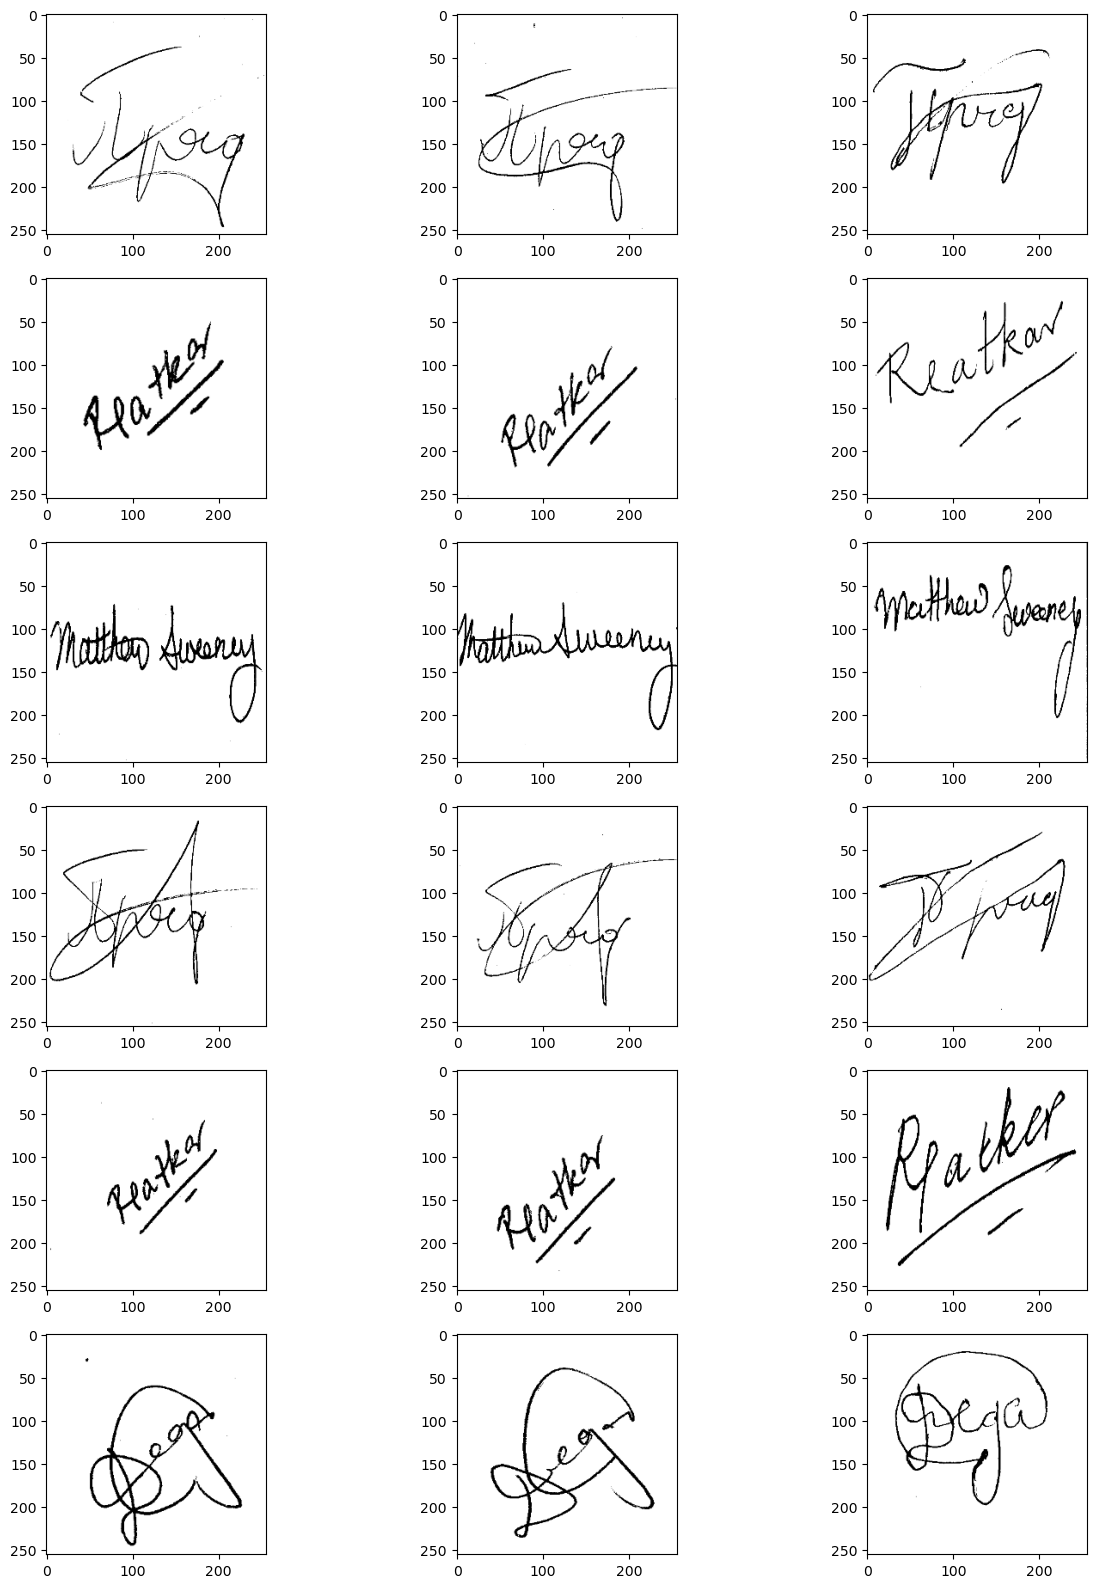

In [9]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_dir,train_triplet, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

## Creating the Model
Unlike a conventional CNN, the Siamese Network does not classify the images into certain categories or labels, rather it only finds out the distance between any two given images. If the images have the same label, then the network should learn the parameters, i.e. the weights and the biases in such a way that it should produce a smaller distance between the two images, and if they belong to different labels, then the distance should be larger

Siamese Network Image
![](https://miro.medium.com/max/2000/1*05hUCDHhnl4hdjqvdVTHtw.png)

In [10]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Encoder
The Encoder is responsible for converting the passed images into their feature vectors. We're using a pretrained model, Xception model which is based on Inception_V3 model. By using transfer learning, we can significantly reduce the training time and size of the dataset.

The Model is connected to Fully Connected (Dense) layers and the last layer normalises the data using L2 Normalisation. (L2 Normalisation is a technique that modifies the dataset values in a way that in each row the sum of the squares will always be up to 1)

In [11]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    
    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

Siamese Network
We're creating a Siamese Network that takes 3 input images, (anchor, postive, negative) and uses the encoder above to encode the images to their feature vectors. Those features are passed to a distance layer which computes the distance between (anchor, positive) and (anchor, negative) pairs.

We'll be defining a custom layer to compute the distance.

Distance Formula:

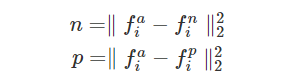

In [12]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def get_siamese_network(input_shape = (256, 256, 3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

83683744/83683744 [==============================] - 4s 0us/step
Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 256, 256, 3  0           []                               
                   

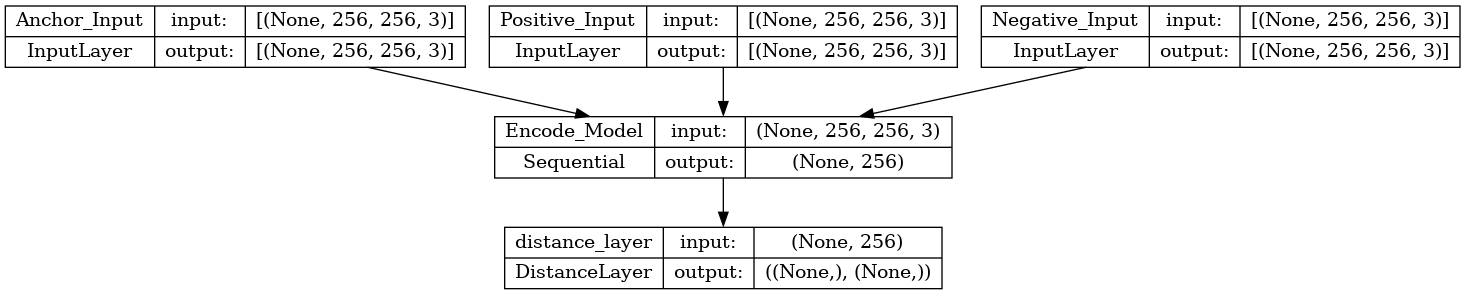

In [13]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

## Putting everything together
We now need to implement a model with custom training loop and loss function so we can compute the triplet loss using the three embeddings produced by the Siamese network.

We'll create a Mean metric instance to track the loss of the training process.

Triplet Loss Function:

### ![](https://miro.medium.com/max/1838/0*AX2TSZNk19_gDgTN.png)

In [14]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1): #1.0
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [15]:
siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

## Training the Model
We'll now be training the siamese_model on batches of triplets. We'll print the training loss, along with additional metrics from testing every epoch. The model weights will also be saved whenever it outperforms the previous max_accuracy.

We're hoping to collect more metrics about the model to evaluate how to increase the accuracy of the model. The epochs have been set to avoid going over Kaggle's time constraint.

### Test Function
test_on_triplets() function will be responsible for testing the model on test_triplets. It'll collect metrics (accuracy, means, stds) by predicting on the train data. We'll also be printing the Accuracy of the model after testing.

In [16]:
def test_on_triplets(batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_dir,test_triplet, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [17]:
import time

save_all = False
epochs = 15
batch_size = 32

max_acc = 0
train_loss = []
test_metrics = []

start = time.time()

for epoch in range(1, epochs+1):
    t = time.time()
    
    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_dir,train_triplet, batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        # print(np.shape(data))
        # print("batch loss : {}".format(loss))
        #if data[0][0,...]==data[1][0,...] or data[0][0,...]==data[2][0,...]:
         #   print('entered')
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    
    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy

# Saving the model after all epochs run
print("Total time: ", time.time() - start, "seconds")
siamese_model.save_weights("siamese_model-final")


EPOCH: 1 	 (Epoch done in 51 sec)
Loss on train    = 0.27176
1/1 [==============================] - 3s 3s/step
Accuracy on test = 1.00000

EPOCH: 2 	 (Epoch done in 25 sec)
Loss on train    = 0.00163
1/1 [==============================] - 0s 94ms/step
Accuracy on test = 1.00000

EPOCH: 3 	 (Epoch done in 25 sec)
Loss on train    = 0.00000
1/1 [==============================] - 0s 92ms/step
Accuracy on test = 1.00000

EPOCH: 4 	 (Epoch done in 24 sec)
Loss on train    = 0.00000
1/1 [==============================] - 0s 91ms/step
Accuracy on test = 1.00000

EPOCH: 5 	 (Epoch done in 25 sec)
Loss on train    = 0.00000
1/1 [==============================] - 0s 92ms/step
Accuracy on test = 1.00000

EPOCH: 8 	 (Epoch done in 25 sec)
Loss on train    = 0.00000
1/1 [==============================] - 0s 81ms/step
Accuracy on test = 1.00000

EPOCH: 9 	 (Epoch done in 24 sec)
Loss on train    = 0.00000
1/1 [==============================] - 0s 79ms/step
Accuracy on test = 1.00000

EPOCH: 10 	 (E

## Using the Model
Now that we've finished training our model, we need to extract the encoder so that we can use it to encode images and then get use the feature vectors to compute the distance between those images.

We'll also be saving the encoder for later use.

In [18]:
siamese_model.layers[0].layers[3]

In [19]:
def extract_encoder(model):
    encoder = get_encoder((256, 256, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.save("encoder.h5")
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_9 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 lambda_1 (Lambda)           (None, 256)               0         
                                                      

## Classify Images
To compute the distance between the encodings of the images, we'll be using distance formula. Distance over a certain threshold to be "different" and below the threshold as "same".

In [20]:
def classify_images(face_list1, face_list2, threshold=0.8): # 0.96875
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    print(distance)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction

1/1 [==============================] - 0s 31ms/step
[0.39271516 0.2285622  0.20437121 0.50411046 0.21019284 0.23743969
 0.19983763 0.19392489 0.10914253 0.4525072  1.7112193  0.1942071
 0.18699118 0.24977009 0.14112082 0.35398632]
1/1 [==============================] - 0s 65ms/step
[1.8653338  1.862868   1.862868   1.9324919  1.7066109  1.759822
 1.759822   1.6312203  1.9000857  1.6312203  1.9115556  1.4825213
 0.92364883 1.4825213  1.862868   1.8636785 ]

Accuracy of model: 0.96875



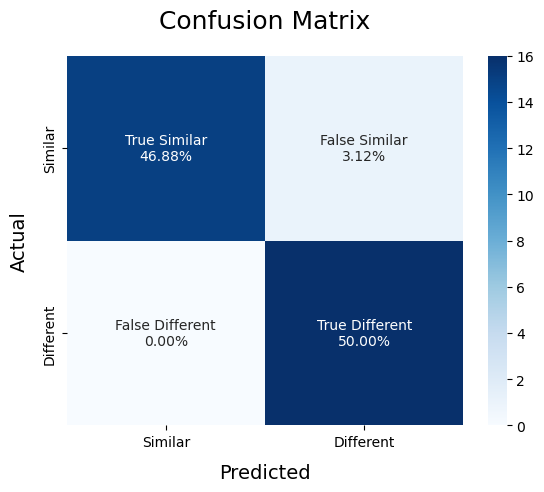

In [21]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_dir,test_triplet, batch_size=16):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)

In [22]:
print(pos_list)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [23]:
model = tf.keras.models.load_model('/kaggle/working/encoder.h5')

In [24]:
def classify_images(face_list1, face_list2, threshold=0.85): # 0.96875
    # Getting the encodings for the passed faces
    tensor1 = model.predict(face_list1)
    tensor2 = model.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    print(distance)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction

### If distance <= Threshold(0.85) --> Similler(label = 0) else, Different(label=1)

In [25]:
x = '/kaggle/input/signature-verification-and-identification/Test/PersonA/Copy of personA_29.png'
y = '/kaggle/input/signature-verification-and-identification/Test/PersonA/Copy of personA_27.png'
a=cv2.imread(x)
b=cv2.imread(y)
a=cv2.resize(a,(256,256))
b=cv2.resize(b,(256,256))
a = preprocess_input(a)
b = preprocess_input(b)
distance=classify_images(np.expand_dims(a,axis=0),np.expand_dims(b,axis=0))
print(distance)

1/1 [==============================] - 0s 23ms/step
[0.1939249]
[0]
